In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from fiona.crs import from_epsg

from li_dbs import DataBridge
from utils import PHL_CRS, create_point_geometry, reproject_gdf

Read in data

In [2]:
remediations_buffer = gpd.read_file('../data/remediations_buffer.shp')

In [3]:
with DataBridge.DataBridge() as con:
    sql = '''
    SELECT * FROM
    (
        SELECT 
            EXTRACT(year FROM dispatch_date_time) year, 
            EXTRACT(month FROM dispatch_date_time) month, 
            text_general_code,
            point_x x,
            point_y y
        FROM
            gis_police.incidents_part1_part2
        WHERE
            dispatch_date_time >= TO_DATE('01/JAN/2016','dd/mon/yyyy')
    )
    WHERE 
        month > 3
        AND month < 12
    '''
    crimes = pd.read_sql(sql=sql, con=con) \
               .dropna()

A lot of these types of crimes are pretty similar, let's group the similar ones together. Our categories for crime types will be: Violent_Crime, Theft, and Other.

In [4]:
crimes_dict = {
              'Vandalism/Criminal Mischief': 'Other',
              'Robbery Firearm': 'Theft',
              'Thefts': 'Theft',
              'Other Assaults': 'Violent Crime',
              'Theft from Vehicle': 'Theft',
              'Fraud': 'Other',
              'Aggravated Assault No Firearm': 'Violent Crime',
              'Burglary Non-Residential': 'Theft',
              'Forgery and Counterfeiting': 'Theft',
              'Disorderly Conduct': 'Other',
              'Burglary Residential': 'Theft',
              'All Other Offenses': 'Other',
              'Aggravated Assault Firearm': 'Violent Crime',
              'Robbery No Firearm': 'Theft',
              'Narcotic / Drug Law Violations': 'Other',
              'Vagrancy/Loitering': 'Other',
              'Other Sex Offenses (Not Commercialized)': 'Other',
              'Arson': 'Other',
              'Rape': 'Other',
              'Recovered Stolen Motor Vehicle':'Theft',
              'Liquor Law Violations': 'Other',
              'Weapon Violations': 'Violent Crime',
              'Public Drunkenness': 'Other',
              'Embezzlement': 'Other',
              'Prostitution and Commercialized Vice': 'Other',
              'Receiving Stolen Property': 'Other',
              'Offenses Against Family and Children': 'Other',
              'Gambling Violations': 'Other',
              'DRIVING UNDER THE INFLUENCE': 'Other',
              'Motor Vehicle Theft': 'Theft',
              'Homicide - Criminal': 'Violent Crime',
              'Homicide - Criminal': 'Violent Crime',
              'Homicide - Justifiable': 'Violent Crime', 
              'Homicide - Gross Negligence': 'Violent Crime'
              }
crimes['Crime Category'] = crimes['TEXT_GENERAL_CODE'].map(crimes_dict)

Build geometry for crimes

In [5]:
crimes_geometry = create_point_geometry(df=crimes, x_col='X', y_col='Y')

Transform the pandas dataframe to a geopandas geodataframe

In [6]:
crimes = gpd.GeoDataFrame(crimes, geometry=crimes_geometry)

Reproject the data to the coordinate system used by the city

In [7]:
crimes = reproject_gdf(gdf=crimes, start_crs=4326, end_crs=PHL_CRS)

Set seaborn settings

In [8]:
# set the background colour of the plot to white
sns.set(style="whitegrid")

# setting the plot size for all plots
sns.set(rc={'figure.figsize':(15, 8)})

Read city limits shapefile

In [9]:
city_limits = gpd.read_file('../data/City_Limits.shp')
city_limits = city_limits.to_crs(crimes.crs)

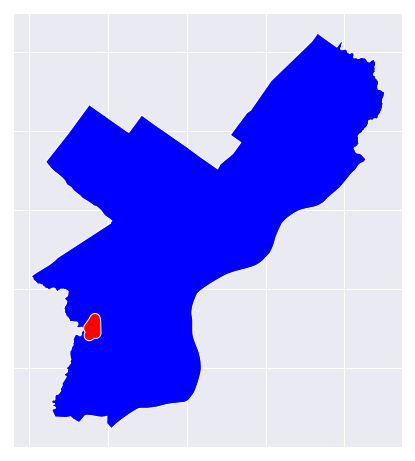

In [10]:
fig, ax = plt.subplots()
city_limits.plot(ax=ax, color='blue')
remediations_buffer.plot(ax=ax, color='red', markersize=5)
# Remove axes tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../figures/city_view.svg')

In [11]:
remediations = gpd.read_file('../data/remediations.shp')

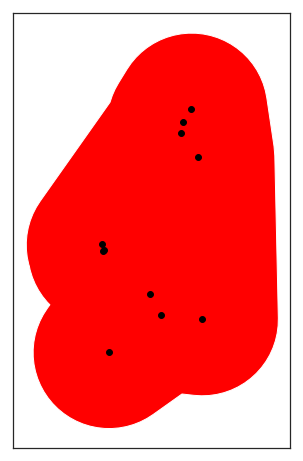

In [12]:
sns.set(style="white")

fig, ax = plt.subplots()
remediations_buffer.plot(ax=ax, color='red')
remediations.plot(ax=ax, color='black', markersize=35)
# Remove axes tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../figures/remediation_sites.png')

Clip the crimes to remove ones outside the buffered remediation area

In [13]:
poly = remediations_buffer.geometry.unary_union
crimes_clip = crimes[crimes.geometry.intersects(poly)]

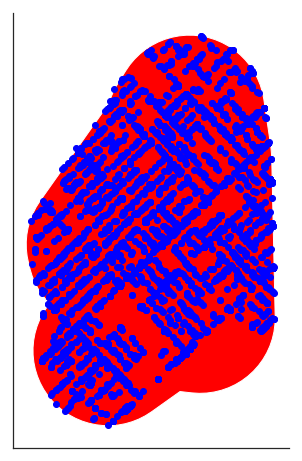

In [14]:
sns.set(style="white")

fig, ax = plt.subplots()
remediations_buffer.plot(ax=ax, color='red', markersize=5)
crimes_clip.plot(ax=ax, color='blue')
# Remove spines
sns.despine(left=False, bottom=False)
# Remove axes tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

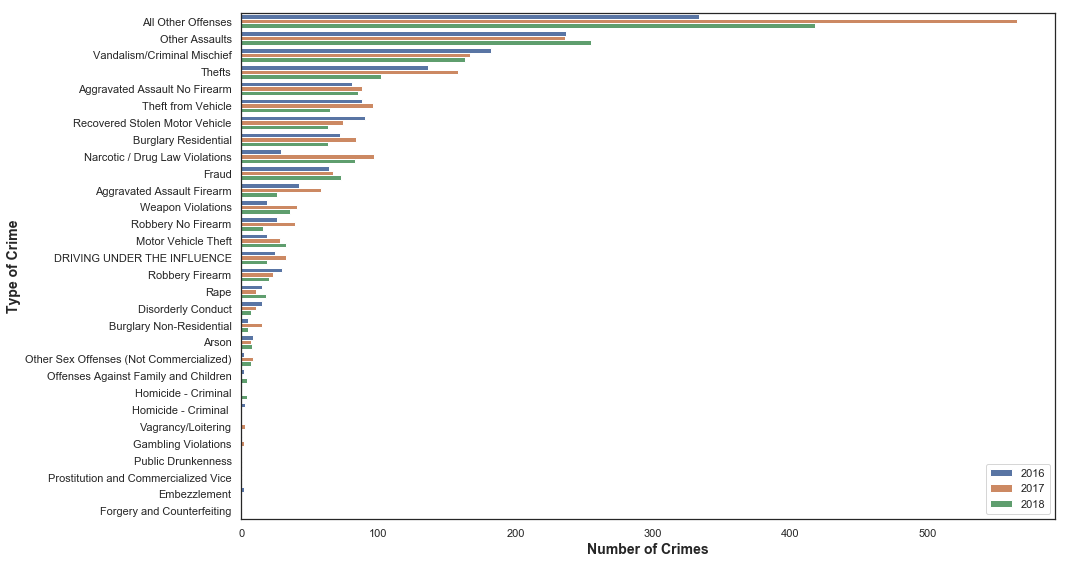

In [15]:
# create a countplot
sns.countplot(y='TEXT_GENERAL_CODE', 
              hue='YEAR',
              data=crimes_clip,
              order=crimes_clip['TEXT_GENERAL_CODE'].value_counts().index)
plt.xlabel('Number of Crimes', size=14, weight='bold')
plt.ylabel('Type of Crime', size=14, weight='bold')
plt.tight_layout()
plt.legend(loc='lower right')

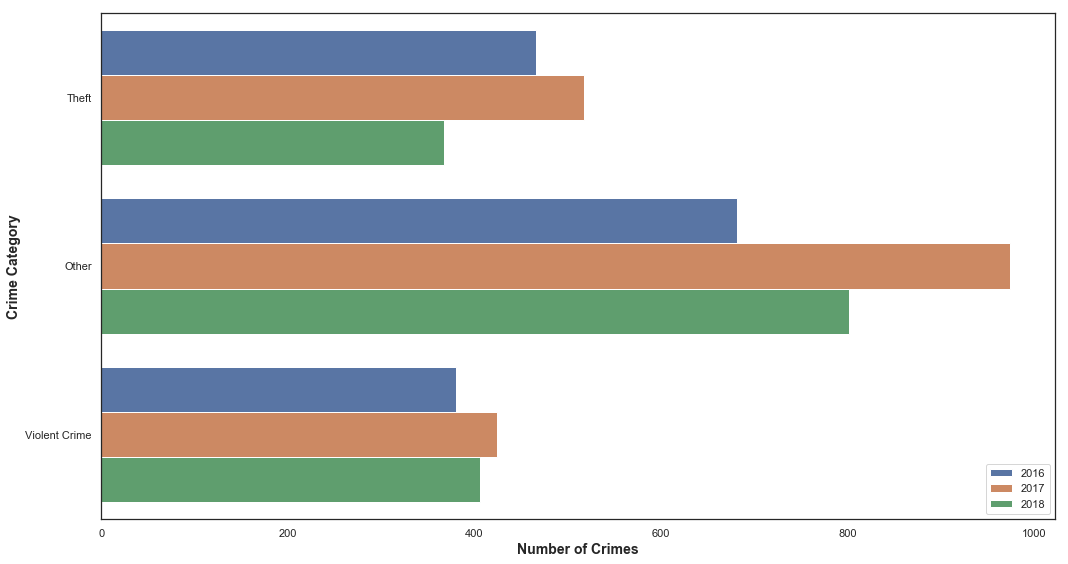

In [16]:
sns.countplot(y='Crime Category', 
              hue='YEAR',
              data=crimes_clip)
plt.xlabel('Number of Crimes', size=14, weight='bold')
plt.ylabel('Crime Category', size=14, weight='bold')
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig('../figures/crimes_by_category.svg')

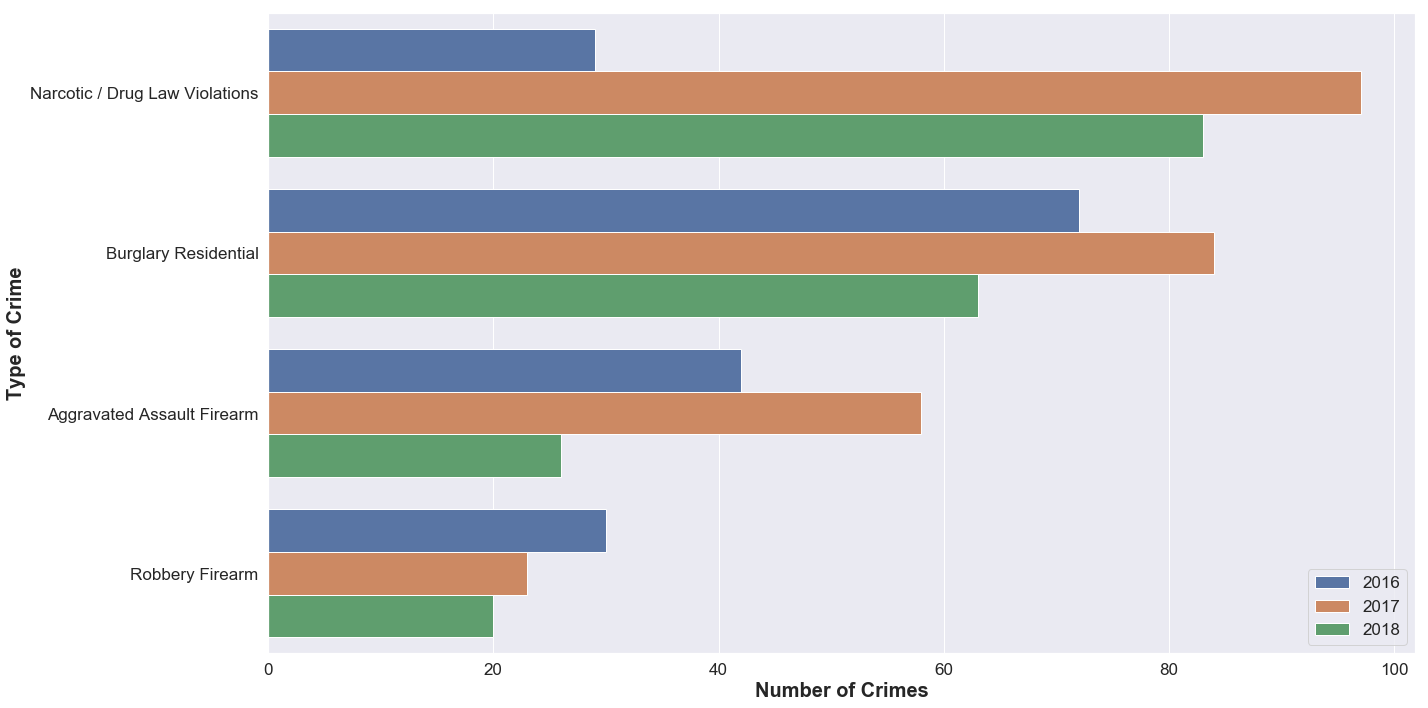

In [17]:
crime_types = ['Narcotic / Drug Law Violations', 'Burglary Residential', 'Robbery Firearm', 'Aggravated Assault Firearm']

sns.set(rc={'figure.figsize':(20, 10)})

sns.countplot(y='TEXT_GENERAL_CODE', 
              hue='YEAR',
              data=crimes_clip.loc[crimes_clip['TEXT_GENERAL_CODE'].isin(crime_types)])
plt.xlabel('Number of Crimes', size=20, weight='bold')
plt.ylabel('Type of Crime', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/crimes_by_type.svg')

No handles with labels found to put in legend.


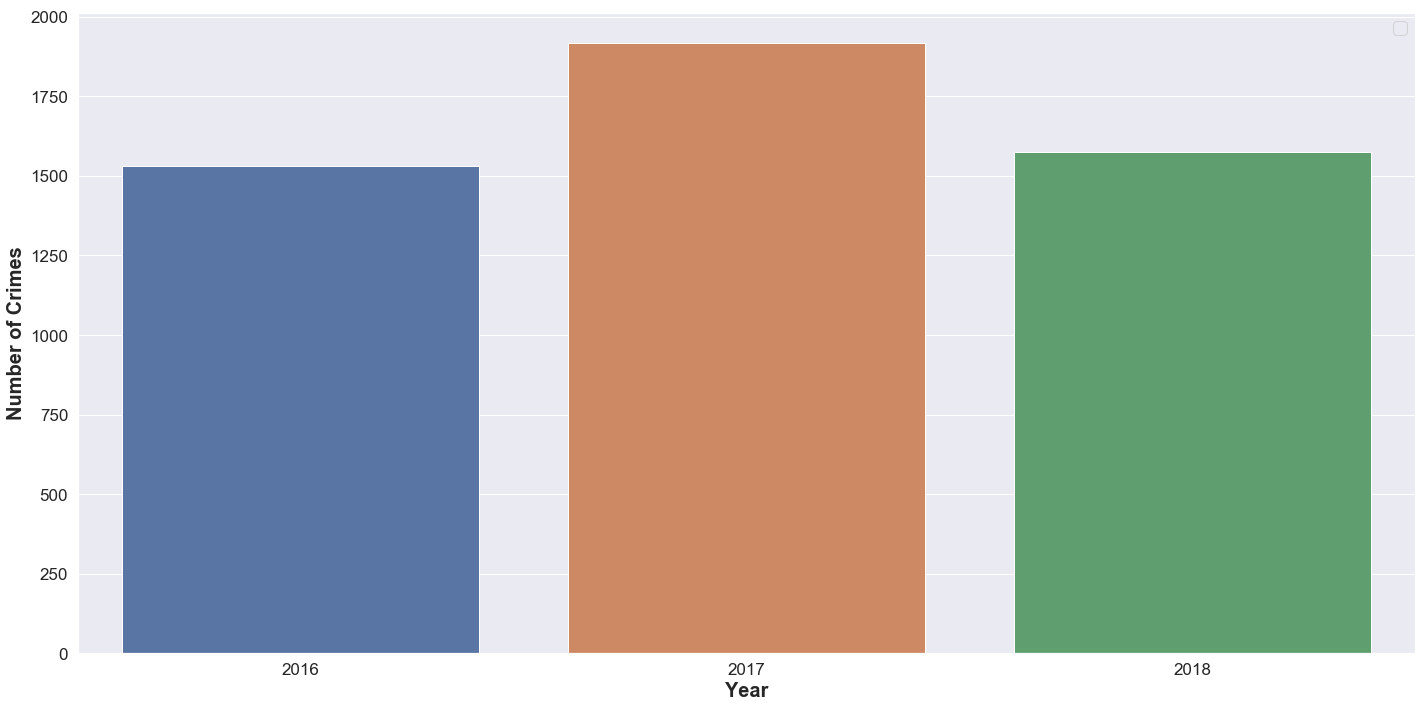

In [24]:
ax = sns.countplot(x='YEAR', 
                   data=crimes_clip)
plt.xlabel('Year', size=20, weight='bold')
plt.ylabel('Number of Crimes', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/crimes_by_year.svg')